# Computing Zonal Statistics with ASTER Thermal Infrared GeoTIFFs

AST_L1T: [ASTER Level 1 Precision Terrain Corrected Registered At-Sensor Radiance](https://lpdaac.usgs.gov/products/ast_l1tv003/)

### AST_L1T GeoTIFFs

The TIR AST_L1T GeoTIFFs: 
* B14 (Red), B12 (Green), B10 (Blue)
* 90 m/px
* Degrees Kelvin scaled from 16-bit to 8-bit ????

### Radiometry:

AST_L1T TIR data are scaled to digital number values for the TIR bands as follows:
* DN of 0 corresponds to "no data"
* DN of 1 corresponds to a radiance of 0 $W m^{-2} sr^{-1} \mu m^{-1}$
* DN of 4094 is the maximum radiance for TIR bands
* DN of 4095 is the value for saturated pixels in TIR bands

At-Sensor Radiance (L) is calculated from DNs using the Unit Conversion Coefficients $[W m^{-2} sr^{-1} \mu m^{-1} / DN]$ :

<div style="font-size: 130%;", align="center">
$L_s = (DN - 1) \times ucc$
</div>

Brightness temperature is calculated from radiances (L) using the constants K1 $[W m^{-2} sr^{-1} \mu m^{-1}]$ and K2 $[K]$ in the Planck formula:

<div style="font-size: 170%;", align="center">
$T_b = \frac{K_2}{ln (\frac{K_1}{L_s} + 1)}$
</div>

| Band | Wavelength ($\mu m$)| ucc          | K1      | K2      |
| ---  | ---                 | ---          | ---     | ---     |
| 10   | 8.125–8.475         | 6.822 x 10-3 | 3047.47 | 1736.18 |
| 11   | 8.475–8.825         | 6.780 x 10-3 | 2480.93 | 1666.21 |
| 12   | 8.925–9.275         | 6.590 x 10-3 | 1930.80 | 1584.72 |
| 13   | 10.250–10.950       | 5.693 x 10-3 | 865.65  | 1349.82 |
| 14   | 10.950–11.650       | 5.225 x 10-3 | 649.60  | 1274.49 |



---
See also: *Jiménez-Muñoz, J. C., & Sobrino, J. A. (2009). A single-channel algorithm for land-surface temperature retrieval from ASTER data. IEEE Geoscience and Remote Sensing Letters, 7(1), 176-179.*

*Portions of this notebook were derived from [this example with Sentinel satellite imagery](https://github.com/shakasom/zonalstatistics/).*

---
To do:
- fix nodata issue in masking (you can see all the zeros I end up with in this histograms, which I want to convert to nan values so that I can ignore them)

---

In [73]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.mask import mask
import matplotlib.pyplot as plt

#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar
#https://pypi.org/project/matplotlib-scalebar/
#ax.add_artist(Scalebar(res)) where res is the pixel resolution in meters
#If already set imshow(extent=extent) parameter, use res=1.0

In [107]:
def tir_dn2rad(DN, band):
    '''Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14).'''
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN-1.) * ucc[band-10]
    return rad

def tir_rad2tb(rad, band):
    '''Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14).'''
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    tb = k2[band-10] /  np.log((k1[band-10]/rad) + 1)
    return tb

### Open an ASTER TIR image

In [74]:
src = rio.open(r"\\j-lundquist-3.ce.washington.edu\storage\spestana\ASTER\AST_L1T\geotiff\T\T_Tuolumne-and-CUES\T_both\AST_L1T_00311262018060119_20181128034140_15697_T.tif")

In [75]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 932,
 'height': 824,
 'count': 3,
 'crs': CRS({'init': 'epsg:32611'}),
 'transform': Affine(90.0, 0.0, 269865.0,
        0.0, -90.0, 4232115.0)}

In [76]:
src.count, src.width, src.height

(3, 932, 824)

(array([282626.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  57924., 427418.]),
 array([  0. ,  17.2,  34.4,  51.6,  68.8,  86. , 103.2, 120.4, 137.6,
        154.8, 172. ]),
 <a list of 10 Patch objects>)

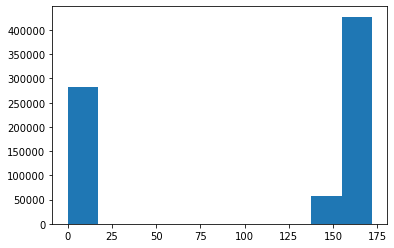

In [131]:
plt.hist(a.astype(np.uint16).flatten())

In [136]:
a = src.read(1)
a = a.astype('float32')
a[a==0] = np.nan

In [137]:
b = tir_dn2rad(a, 14)
c = tir_rad2tb(b,14)

(array([282626.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  57924., 427418.]),
 array([  0. ,  17.2,  34.4,  51.6,  68.8,  86. , 103.2, 120.4, 137.6,
        154.8, 172. ]),
 <a list of 10 Patch objects>)

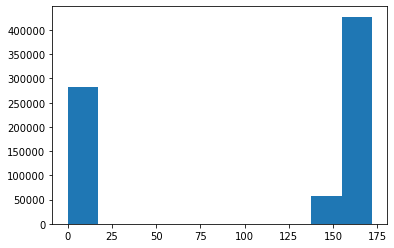

In [144]:
plt.hist(src.read(1).flatten())

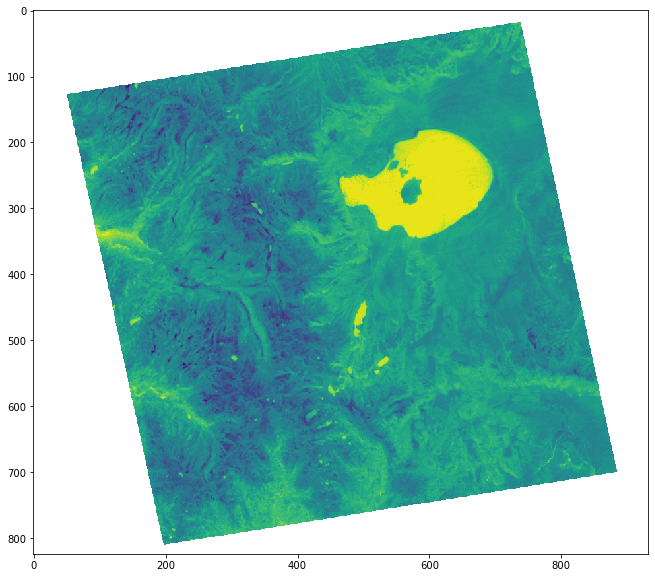

In [78]:
fig, ax = plt.subplots(1, figsize=(12, 10))
rioplt.show(a, ax=ax)
plt.show()

### Open a shapefile
(these will be the GOES pixel footprints)

In [79]:
testshape = gpd.read_file(r"C:\Users\steve\Desktop\test1.shp")
testshape.head()

,id,geometry
0,0,"POLYGON ((-119.31453 37.86398, -119.30652 37.9..."


Make sure our shapefile is the same CRS as the ASTER TIR image

In [80]:
print('ASTER CRS: {}'.format(src.crs))
print('Shapefile CRS: {}'.format(testshape.crs))

ASTER CRS: +init=epsg:32611
Shapefile CRS: {'init': 'epsg:4326'}


In [81]:
testshape = testshape.to_crs(src.crs)

In [82]:
print('ASTER CRS: {}'.format(src.crs))
print('Shapefile CRS: {}'.format(testshape.crs))

ASTER CRS: +init=epsg:32611
Shapefile CRS: +init=epsg:32611


### Plot the shapefile on top of the ASTER image to see where we are

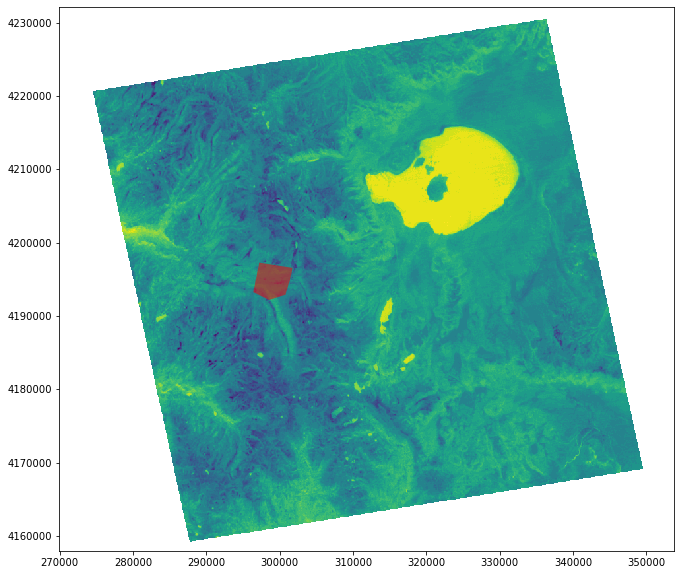

In [83]:
fig, ax = plt.subplots(figsize=(12, 10))
rioplt.show(a, transform=src.transform, ax=ax)
testshape.plot(ax=ax, color="red", alpha=.50)
plt.show();

### Mask the ASTER TIR image to the area of the shapefile

In [ ]:
wa_elev_masked = ma.masked_values (wa_elev, wa_srtm.nodata)

In [86]:
src

<open DatasetReader name='\\j-lundquist-3.ce.washington.edu\storage\spestana\ASTER\AST_L1T\geotiff\T\T_Tuolumne-and-CUES\T_both\AST_L1T_00311262018060119_20181128034140_15697_T.tif' mode='r'>

In [62]:
masked, mask_transform = mask(dataset=src, 
                              shapes=testshape.geometry,
                              crop=True,
                              all_touched=True,
                              filled=True)

# We still have all three bands in here
masked.shape

(3, 57, 61)

### Calculate zonal statistics for this area
(mean, max, min, std:)

In [63]:
means_per_band = masked.mean(axis=(1,2))
max_per_band = masked.max(axis=(1,2))
min_per_band = masked.min(axis=(1,2))
std_per_band = masked.std(axis=(1,2))

### Plots

In [64]:
def norm_dn(array,percentiles=None):
    '''Return a numpy array normalized to float32 values within 0.0 - 1.0, 
    given an input array and optional percentiles to use rather than the minimum and maximum'''
    
    if percentiles == None:
        percentiles = (0, 100)
    else:
        assert (len(percentiles) == 2), "percentiles must be a list: [min%, max%]"
        assert (percentiles[1] <= 100), "max percentile cannot be greater than 100"
        assert (percentiles[0] >= 0), "min percentile cannot be less than 0"


    array_min, array_max = np.percentile(array,percentiles)
    array_range = array_max - array_min
    norm_array = (array - array_min) / array_range
    
    return np.float32(norm_array)


Band_n: 0
Mean: 115.25337935001438
Max: 162
Min: 0
Std: 69.8172679079356
Band_n: 1
Mean: 104.23497267759562
Max: 147
Min: 0
Std: 63.152710879093036
Band_n: 2
Mean: 99.95427092320966
Max: 141
Min: 0
Std: 60.56540644770467


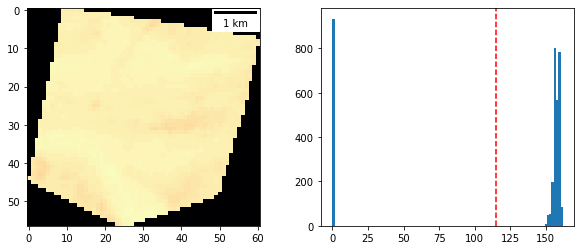

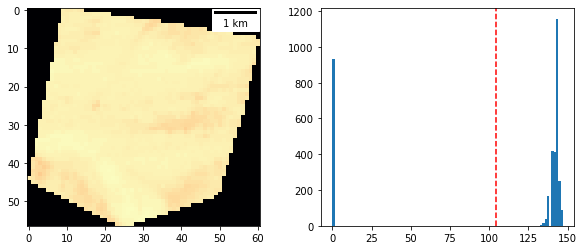

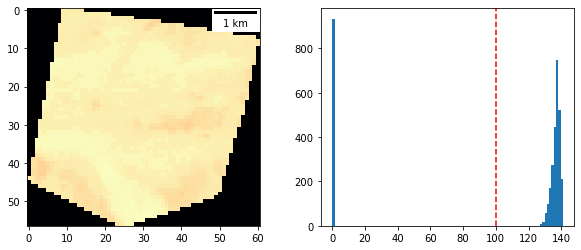

In [69]:
# For each band in the ASTER image
for band_n in range(src.count):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,4), gridspec_kw={'width_ratios': [1, 1]})
    
    # Plot image
    image_data = norm_dn(masked[band_n],[15,85])
    rio.plot.show(image_data,
                  ax=ax[0],
                  cmap='magma')
    scalebar = ScaleBar(src.res[0]) # get image resolution from original raster image
    ax[0].add_artist(scalebar)
    
    # Print zonal statistics
    print('Band_n: {}\nMean: {}\nMax: {}\nMin: {}\nStd: {}'.format(band_n,
                                                                   means_per_band[band_n],
                                                                   max_per_band[band_n],
                                                                   min_per_band[band_n],
                                                                   std_per_band[band_n]))
    # Plot histogram
    #rio.plot.show_hist(
    #masked[band_n], bins=50, lw=0.0, stacked=False, alpha=0.3, ax=ax[1],
    #histtype='stepfilled', title="Histogram", c='r')
    values = masked[band_n].flatten()
    ax[1].hist(values, bins=100);
    ax[1].axvline(x=means_per_band[band_n], c='r', linestyle='--')